## LLM API call using OpenAI API

### Tools

In [ ]:
from openai import OpenAI
import os
import base64
from pydantic import BaseModel, Field
from typing import Literal, Optional, Annotated

# for plotting images
import matplotlib.pyplot as plt
from PIL import Image

### OpenAI client setup

In order to use OpenAI API you will need an OPENAI_API_KEY. You then need to create .env file with this line inside:

``OPENAI_API_KEY="YOUR_OPENAI_API_KEY" ``

In [2]:
# load the env variable (API key)
from dotenv import load_dotenv
load_dotenv()

In [ ]:
# Use environment variables
key = os.getenv("OPENAI_API_KEY")

# construct client instance
client = OpenAI(api_key=key)

### Loading the Data

In [4]:
sample_path = os.path.join(os.getcwd(), '../user_inputs/user_sample1.jpg')
sample_probs_path = os.path.join(os.getcwd(), '../results/xai_output/model_output.csv')  # Probabilities output by the model for the sample

# XAI methods outputs
xai_gradcam_output_path = os.path.join(os.getcwd(), '../results/xai_output/user_sample1_xai_gradcam.png')
xai_shap_output_path = os.path.join(os.getcwd(), '../results/xai_output/user_sample1_xai_shap.png')
xai_influence_output_path = os.path.join(os.getcwd(), '../results/xai_output/user_sample1_influence_function.csv')

In [5]:
# Function to encode the images to base64 byte objects in string format
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

# encode the xai output images
xai_gradcam_enc = encode_image(xai_gradcam_output_path)
xai_shap_enc = encode_image(xai_shap_output_path)

# Read in the influence function output
with open(xai_influence_output_path, "r", encoding="utf-8") as f:
    xai_influence_function = f.read()

# Read in the sample probabilities output by the model
with open(sample_probs_path, "r",  encoding="utf-8") as f:
    sample_probs = f.read()

### Instructions

In constructing the instructions for LLM, I've followed OpenAI's best prompting practices available [here](https://cookbook.openai.com/examples/gpt4-1_prompting_guide)

In [6]:
# read in the instructions
with open(os.path.join(os.getcwd(), "../data/llm/llm_instructions.md"), "r", encoding="utf-8") as f:
    instructions = f.read()

### LLM API call

We use a flagship model from OpenAI, GPT-4.1 (model snapshot: 2025-04-14). According to the company's documentation, it is highly capable at complex task while expressing strict adherance to instructions.  

In [7]:
response = client.responses.create(
    model="gpt-4.1-2025-04-14",
    input=[
        {
            "role": "developer",
            "content" : instructions
        },
        {
            "role": "user",
            "content": [
                { 
                    "type": "input_text",
                    "text": str(sample_probs) }, # sample probabilities
                { 
                    "type": "input_text",
                    "text": xai_influence_function }, # influence function output
                    
                {
                    "type": "input_image",
                    "image_url": f"data:image/png;base64,{xai_gradcam_enc}", # GradCAM output, base64-encoded PNG file
                    "detail": "auto"
                },
                {
                    "type": "input_image",
                    "image_url": f"data:image/png;base64,{xai_shap_enc}", # SHAP output, base64-encoded PNG file
                    "detail": "auto"
                },

            ],
        }
    ],
    temperature=0.0
)

print(response.output_text)

**Summary**

The AI analysis suggests this skin lesion is borderline between benign and malignant, with no clear decision.

**Confidence Level** 

The model is 51% confident, meaning there's a 49% chance this assessment could be incorrect.

**Key Findings**

- GradCAM: The heat map shows the AI paid closest attention to the bright red area in the lower centre of the image when making its prediction, while the blue areas contributed little to the decision.
- SHAP: The analysis shows that red features in the centre and upper left of the image most strongly influenced the AI's prediction toward "Benign", while green areas to the lower right moderately pushed the model's prediction toward "Malignant".
- The focal areas for GradCAM and SHAP are not fully aligned, as GradCAM highlights the lower centre, while SHAP highlights the centre and upper left.
- Influence Function: 92% of the most influential training cases were "Benign", while 8% were "Malignant". Only 3% of these influential traini

In [8]:
# Tokens cost
response.usage.total_tokens

7027

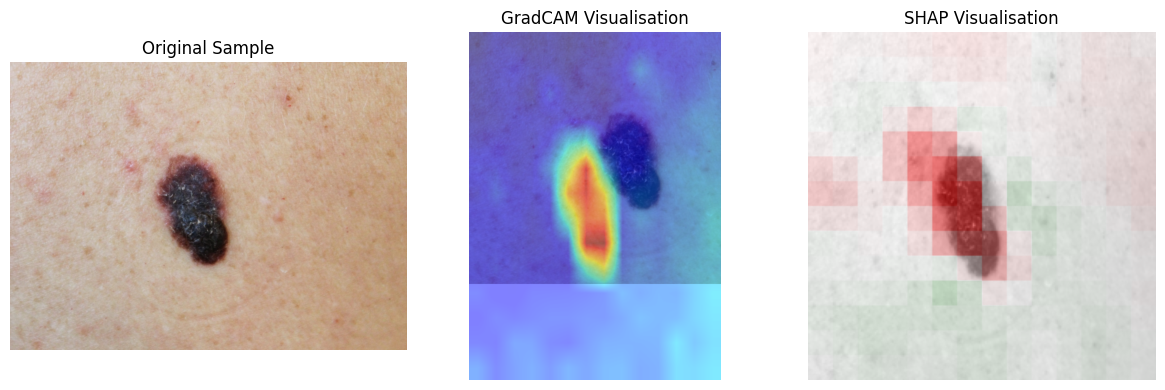

In [9]:
# Load and display xai images for context
img1 = Image.open(sample_path)
img2 = Image.open(xai_gradcam_output_path)
img3 = Image.open(xai_shap_output_path)


fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(img1)
axes[0].axis('off')
axes[0].set_title('Original Sample')
axes[1].imshow(img2)
axes[1].axis('off')
axes[1].set_title('GradCAM Visualisation')
axes[2].imshow(img3)
axes[2].axis('off')
axes[2].set_title('SHAP Visualisation')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


### Write the LLM interpretaton to .txt file

In [10]:
with open(file=os.path.join(os.getcwd(), '../results/xai_output/llm_output.txt'), mode="w", encoding="utf-8") as f:
    f.write(response.output_text)

### Parse LLM Output for Quantitative Analysis

The call below parses the LLM interpretation while extracting cruicial insights to enable a quantitative analysis against the original CNN prediction. 

Please note, according to llm_instructons.md we expect the LLM to interpret predictions made by the CNN that are `>= 0.5 and < 0.6` as **borderline**

In [11]:
class Prediction(BaseModel):
    prediction: Literal['Benign', 'Malignant', 'Borderline'] = Field(
        description="'Benign' for when the AI analysis suggests low or moderately low concern for malignancy; 'Malignant' for when the AI analysis indicates high or moderately high concern for malignancy; 'Borderline' for when the AI analysis indicates the skin lesion is borderline."
        )
    confidence: Annotated[int, Field(description="Model confidence, as indicated in Confidence Level section")]


extraction = client.responses.parse(
    model="gpt-4o-2024-08-06",
    input=[
        {
            "role": "system",
            "content": "You are an expert at structured data extraction. You will be given unstructured text from AI analysis and should convert it into the given structure.",
        },
        {
            "role": "user", 
            "content": response.output_text
            },
    ],
    text_format=Prediction,
)

extracted_data = extraction.output_parsed.model_dump()

In [12]:
extracted_data

{'prediction': 'Borderline', 'confidence': 51}

In [13]:
# Write extracted_data to a csv file for analysis
import csv

with open(file=os.path.join(os.getcwd(), '../results/xai_output/parsed_llm_output.csv'), mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(extracted_data.keys())
    writer.writerow(extracted_data.values())